In [13]:
import csv
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Constructing Graph of Citations

In [14]:
INPUT_CSV = "papers.csv"

def Build_Directed_Graph(csv_file):
    G = nx.DiGraph()
    with open(csv_file, newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            paper_id = row["paperId"].strip()
            title = row["title"].strip()
            refs = row["references"].split(";") if row["references"] else []

            G.add_node(paper_id, title=title)
            for ref_id in refs:
                ref_id = ref_id.strip()
                if ref_id:
                    G.add_edge(paper_id, ref_id)
    print(f"Graph built with {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    return G

G = Build_Directed_Graph(INPUT_CSV)

# Remove isolated nodes
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)
print(f"Graph after removing {len(isolated_nodes)} isolated nodes: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Graph built with 150 nodes, 107 edges
Graph after removing 118 isolated nodes: 32 nodes, 107 edges


#### Visualizing Graph of Citations

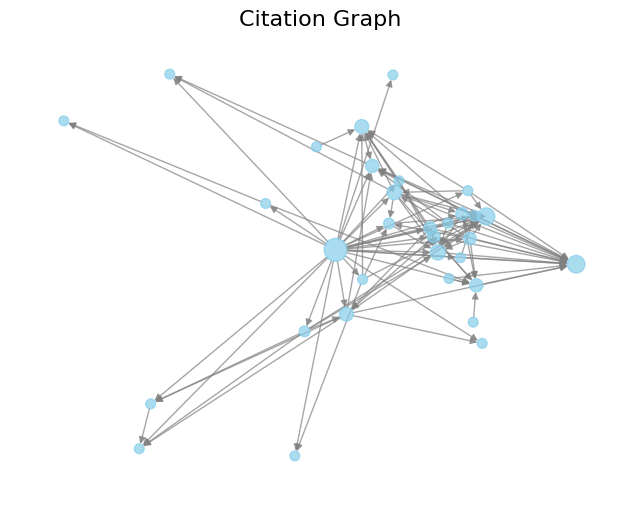

In [15]:
# node size depends on degree (for better visualization)
node_sizes = [max(50, 10 * G.degree(n)) for n in G.nodes()]

pos = nx.spring_layout(G, seed=42, k=0.5, iterations=100)

plt.figure(figsize=(8, 6))
nx.draw_networkx(
    G,
    pos,
    with_labels=False,     
    node_size=node_sizes,
    node_color="skyblue",
    edge_color="gray",
    alpha=0.7,
    arrowsize=10
)

plt.title("Citation Graph", fontsize=16)
plt.axis("off")
plt.show()

#### Page-Rank Algorithm

In [16]:
def PageRank(G, damping_factor=0.85, tolerance=1e-6,max_iterations = 1000):
    
    N = G.number_of_nodes()
    nodes = list(G.nodes())

    # Initialize Page Rank with zeros
    PR = {n: 0 for n in nodes}

    differences = []

    # Computing Outdegrees
    out_degree = {n : G.out_degree(n) for n in nodes}

    for iter in range(max_iterations):
        PR_new = {}

        # Rank of nodes with zero outdegree 
        dangling_rank = sum(PR[n] for n in nodes if out_degree[n] == 0)

        for n in nodes:
            rank_sum = 0.0

            # Sum of rank contributions from nodes m such that there is an edge from m -> n
            for m in G.predecessors(n):
                rank_sum += PR[m]/out_degree[m]

            # Add contribution from all dangling nodes
            rank_sum += dangling_rank/N

            PR_new[n] = (1 - damping_factor)  + damping_factor * rank_sum

        diff = sum(abs(PR_new[n] - PR[n]) for n in nodes)
        differences.append(diff)
        PR = PR_new
        
        if diff < tolerance:
            print(f"PageRank converged after {iter+1} iterations")
            last_iteration = iter+1
            break
    
    return PR , differences , last_iteration

PageRank converged after 96 iterations


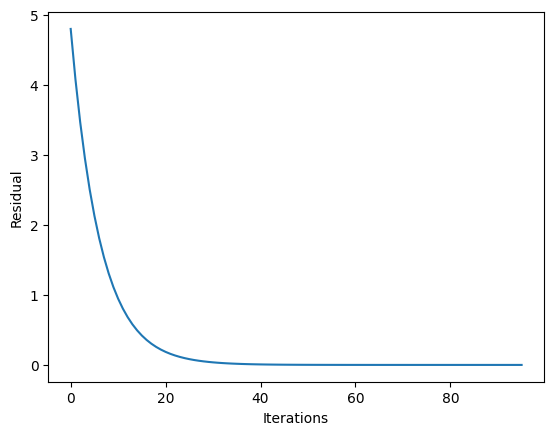

In [17]:
PR , Differences, iterations = PageRank(G)

plt.plot(np.arange(0,iterations),Differences)
plt.xlabel('Iterations')
plt.ylabel('Residual')
plt.show()

In [18]:
# Show top 10 papers
top_papers = sorted(PR.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 papers by PageRank Algorithm:")
for paper_id, score in top_papers:
    print(f"{paper_id[:8]} - {G.nodes[paper_id]['title'][:60]}... | Score: {score:.4f}")

Top 10 papers by PageRank Algorithm:
2e9d221c - Long Short-Term Memory... | Score: 6.4650
6471fd1c - Generating Sequences With Recurrent Neural Networks... | Score: 2.8254
0b544dfe - Learning Phrase Representations using RNN Encoder–Decoder fo... | Score: 1.9721
2e5f2b57 - Gradient Flow in Recurrent Nets: the Difficulty of Learning ... | Score: 1.7442
fa72afa9 - Neural Machine Translation by Jointly Learning to Align and ... | Score: 1.7300
2c03df8b - Deep Residual Learning for Image Recognition... | Score: 1.5519
a6cb3667 - Adam: A Method for Stochastic Optimization... | Score: 1.5085
78a9513e - Effective Self-Training for Parsing... | Score: 1.2112
ac3ee980 - Empirical Evaluation of Gated Recurrent Neural Networks on S... | Score: 0.7539
93499a7c - Effective Approaches to Attention-based Neural Machine Trans... | Score: 0.7024


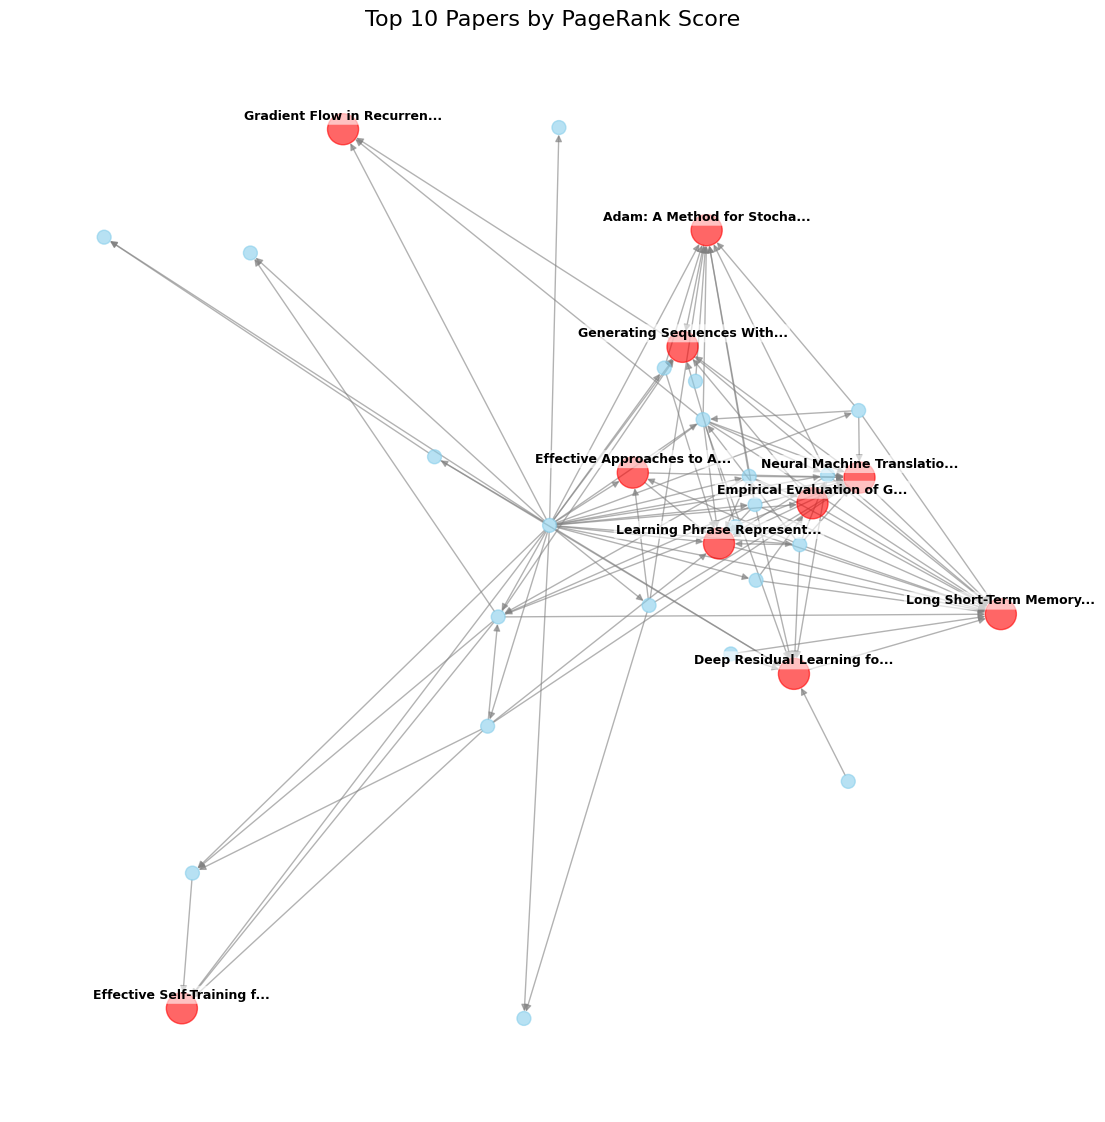

In [19]:
top_nodes = [paper_id for paper_id, _ in top_papers]

# Assign colors — red for top 10, blue for others
node_colors = ["red" if n in top_nodes else "skyblue" for n in G.nodes()]

# Assign sizes — larger for top 10
node_sizes = [500 if n in top_nodes else 100 for n in G.nodes()]

pos = nx.spring_layout(G, seed=42, k=0.6, iterations=100)

plt.figure(figsize=(14, 14))
nx.draw_networkx(
    G,
    pos,
    with_labels=False,
    node_size=node_sizes,
    node_color=node_colors,
    edge_color="gray",
    alpha=0.6,
    arrowsize=10
)

# Label only top 10 nodes
for n in top_nodes:
    x, y = pos[n]
    plt.text(
        x, y + 0.02, 
        G.nodes[n]['title'][:25] + "...", 
        fontsize=9, 
        color="black", 
        fontweight="bold",
        ha="center",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.2")
    )

plt.title("Top 10 Papers by PageRank Score", fontsize=16)
plt.axis("off")
plt.show()


In [23]:
nodes = list(G.nodes())
Citation_Counts = {n : G.in_degree(n) for n in nodes}
data = pd.DataFrame({
    'paper' : list(PR.keys()),
    'PageRank' : list(PR.values()),
    'citations' : [Citation_Counts[node] for node in nodes]
})

Correlation = data['PageRank'].corr(data['citations'])
print("Correlation between PageRank and Citation Counts : ",Correlation)

Correlation between PageRank and Citation Counts :  0.8390347733985899


We can observe a high correlation (~ 0.83) between PageRank and Citation counts